In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
from src import models

device = "cuda:0"
mt = models.load_model("gptj", device=device)

In [4]:
print(f"dtype: {mt.model.dtype}, device: {mt.model.device}, memory: {mt.model.get_memory_footprint()}")

dtype: torch.float16, device: cuda:0, memory: 12219206136


In [5]:
from src import data

dataset = data.load_dataset()

In [6]:
for d in dataset:
    print(d)

Relation(name='capital city', prompt_templates=['The capital city of {} is', 'The political capital of {} is', 'The seat of government for {} is', 'The government of {} is centered in'], samples=[RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='Canada', object='Ottawa'), RelationSample(subject='Mexico', object='Mexico City'), RelationSample(subject='Brazil', object='Bras\\u00edlia'), RelationSample(subject='Argentina', object='Buenos Aires'), RelationSample(subject='Chile', object='Santiago'), RelationSample(subject='Peru', object='Lima'), RelationSample(subject='Colombia', object='Bogot\\u00e1'), RelationSample(subject='Venezuela', object='Caracas'), RelationSample(subject='Spain', object='Madrid'), RelationSample(subject='France', object='Paris'), RelationSample(subject='Germany', object='Berlin'), RelationSample(subject='Italy', object='Rome'), RelationSample(subject='Russia', object='Moscow'), RelationSample(subject='China', object='Beijing

In [7]:
import baukit
import torch
from src.functional import Order1ApproxOutput
from src.utils.misc import visualize_matrix


@torch.no_grad()
@torch.inference_mode(mode=False)
def order_1_approx(
    *,
    mt: models.ModelAndTokenizer,
    prompt: str,
    h_layer: int,
    h_index: int,
    z_token_indices: list[int],
    z_layer: int | None = None,
    z_index: int | None = None,
    inputs=None,
):
    if z_layer is None:
        z_layer = mt.model.config.n_layer - 1
    if z_index is None:
        z_index = -1
    if inputs is None:
        inputs = mt.tokenizer(prompt, return_tensors="pt").to(mt.model.device)

    # Precompute everything up to the subject, if there is anything before it.
    past_key_values = None
    input_ids = inputs.input_ids
    _h_index = h_index
    if _h_index > 0:
        outputs = mt.model(input_ids=input_ids[:, :_h_index], use_cache=True)
        past_key_values = outputs.past_key_values
        input_ids = input_ids[:, _h_index:]
        _h_index = 0
    use_cache = past_key_values is not None

    # Precompute initial h and z.
    [h_layer_name, z_layer_name] = models.determine_layer_paths(mt, [h_layer, z_layer])
    with baukit.TraceDict(mt.model, (h_layer_name, z_layer_name)) as ret:
        outputs = mt.model(
            input_ids=input_ids,
            use_cache=use_cache,
            past_key_values=past_key_values,
        )
    h = ret[h_layer_name].output[0][0, _h_index]
    z = ret[z_layer_name].output[0][0, z_index]

    # Now compute J and b.
    def compute_z_from_h(h: torch.Tensor) -> torch.Tensor:
        def insert_h(output: tuple, layer: str) -> tuple:
            if layer != h_layer_name:
                return output
            output[0][0, _h_index] = h
            return output

        with baukit.TraceDict(
            mt.model, (h_layer_name, z_layer_name), edit_output=insert_h
        ) as ret:
            mt.model(
                input_ids=input_ids,
                past_key_values=past_key_values,
                use_cache=use_cache,
            )
        z = ret[z_layer_name].output[0][0, -1]
        z = mt.model.transformer.ln_f(z)

        hidden_size = mt.model.config.hidden_size

        # proj = z.new_zeros(hidden_size, hidden_size)
        # for z_token_index in z_token_indices:
        #     y = mt.model.transformer.wte.weight.data[z_token_index, ..., None]
        #     proj += y @ y.t() / y.norm().pow(2)
        Y = []
        for z_token_index in z_token_indices:
            y = mt.model.transformer.wte.weight.data[z_token_index, ..., None]
            Y.append(y.T[0])
        Y = torch.stack(Y, dim=1).to(torch.float32)
        # proj = Y @ (Y.T @ Y).to(torch.float32).pinverse().to(Y.dtype) @ Y.T
        proj = Y @ (Y.T @ Y).to(torch.float32).pinverse() @ Y.T
        print(torch.linalg.matrix_rank(proj))
        proj = proj.to(mt.model.dtype)
        # print(proj)
        # visualize_matrix(proj)
        result = proj @ z[..., None]
        print(Y.norm().item(), proj.norm().item(), result.norm().item())

        # raise AssertionError()
        return result.squeeze()

    weight = torch.autograd.functional.jacobian(compute_z_from_h, h, vectorize=True)
    bias = z[None] - h[None].mm(weight.t())
    approx = Order1ApproxOutput(
        h=h,
        h_layer=h_layer,
        h_index=h_index,
        z=z,
        z_layer=z_layer,
        z_index=z_index,
        weight=weight,
        bias=bias,
        inputs=inputs.to("cpu"),
        logits=outputs.logits.cpu(),
    )
    return approx

In [8]:
# prompt="Eiffle Tower is located in the city of"
# tokenized = mt.tokenizer(prompt, return_tensors="pt").to(mt.model.device)
# print([(t.item(), mt.tokenizer.decode(t)) for t in tokenized.input_ids[0]])

# output = order_1_approx(
#     mt=mt,
#     prompt="Eiffle Tower is located in the city of",    
#     h_layer=15,
#     h_index=3,
#     z_layer=27,
# )

In [9]:
from dataclasses import dataclass

from src import data, functional, operators
from src.utils import tokenizer_utils

from tqdm.auto import tqdm


def get_icl_prompt(samples, sample, prompt_template):
    others = list(set(samples) - {sample})
    prompt = "\n".join(
        prompt_template.format(x.subject) + f" {x.object}."
        for x in others
    )
    prompt += "\n" + prompt_template.format(sample.subject)
    return prompt


class NewJEstimator(operators.LinearRelationEstimator):

    mt: models.ModelAndTokenizer
    h_layer: int = 9
    z_layer: int = 27

    def __call__(self, relation):
        prompt_templates = relation.prompt_templates[:1]
        samples = relation.samples[:3]

        targets = [x for x in relation.range]
        z_token_indices = self.mt.tokenizer(
            targets,
            return_tensors="pt",
            padding=True,
        ).input_ids[:, 0].tolist()
    
        weights = []
        biases = []
        zs = []
        hs = []
        for prompt_template in prompt_templates:
            for sample in tqdm(samples):
                subject = sample.subject
#                 prompt = prompt_template.format(subject)
                prompt = get_icl_prompt(samples, sample, prompt_template)
                print(prompt, "\n", "---")
                _, h_index = tokenizer_utils.find_token_range(prompt, subject, tokenizer=mt.tokenizer)
                h_index -= 1

                # output = functional.order_1_approx(
                #     mt=self.mt,
                #     prompt=prompt,
                #     h_layer=self.h_layer,
                #     h_index=h_index,
                #     z_layer=self.z_layer,
                # )
                output = order_1_approx(
                    mt=self.mt,
                    prompt=prompt,
                    h_layer=self.h_layer,
                    h_index=h_index,
                    z_token_indices=z_token_indices,
                    z_layer=self.z_layer,
                )
                weights.append(output.weight)
                biases.append(output.bias)
        
                hs.append(output.h)
                zs.append(output.z)

#         weight = weights[0]
        weight = torch.stack(weights).mean(dim=0)
#         weight = torch.eye(len(weight)).to(weight.device, weight.dtype)

        bias = torch.stack(biases).mean(dim=0)
        print(bias.norm())
        bias = bias * .5
        print(bias.norm())

        print("h norm", torch.stack(hs).norm(dim=-1).squeeze().mean())
        print("Jh norm", torch.stack([weight @ h for h in hs]).norm(dim=-1).squeeze().mean())
        print("Jh + b norm", torch.stack([weight @ h + bias * 2 for h in hs]).norm(dim=-1).squeeze().mean())
        print("Jh + b/2 norm", torch.stack([weight @ h + bias for h in hs]).norm(dim=-1).squeeze().mean())
        print("z norm", torch.stack(zs).norm(dim=-1).squeeze().mean())

#         bias = mt.model.transformer.wte.weight.data[z_token_indices].mean(dim=0)

#         hidden_size = weight.shape[0]
#         proj = bias.new_zeros(hidden_size, hidden_size)
#         for z_token_index in z_token_indices:
#             y = mt.model.transformer.wte.weight.data[z_token_index, ..., None]
#             proj += y @ y.t() / y.norm().pow(2)
#         weight = weight @ proj

#         bias = torch.zeros_like(bias)

        return operators.LinearRelationOperator(
            mt=self.mt,
            weight=weight,
            bias=bias,
            h_layer=self.h_layer,
            z_layer=self.z_layer,
            prompt_template=relation.prompt_templates[0],
        )


estimator = NewJEstimator(mt=mt)

relation = dataset[0].set(prompt_templates=[dataset[0].prompt_templates[0]])
# relation = dataset[1].set(prompt_templates=["People in {} speak the language of"])

# relation = data.Relation(
#     name="workplaces",
#     prompt_templates=["{} typically work inside of a"],
#     samples=[
#         data.RelationSample("Nurses", "hospital"),
#         data.RelationSample("Judges", "courtroom"),
#         data.RelationSample("Farmers", "field"),
#         data.RelationSample("Car mechanics", "garage"),
#         data.RelationSample("Teachers", "classroom"),
#     ],
# )

# relation = data.Relation(
#     name="color",
#     prompt_templates=["{} are typically associated with the color"],
#     samples=[
#         data.RelationSample("Bananas", "yellow"),
#         data.RelationSample("Kiwis", "green"),
#         data.RelationSample("Potatoes", "brown"),
#     ],
#     _range=[
#         "pink",
#         "yellow",
#         "red",
#         "green",
#         "blue",
#         "orange",
#         "violet",
#         "magenta",
#         "brown",
#         "black",
#         "white",
#         "purple",
#         "grey",
#         "gray",
#         "maroon",
#     ]
# )
# relation = data.Relation.from_dict({
#     "name": "president elected 1900s",
#     "prompt_templates": [
#         "{} was elected president in the year"
#     ],
#     "samples": [
#         {
#             "subject": "John F. Kennedy",
#             "object": "1960"
#         },
#         {
#             "subject": "Lyndon B. Johnson",
#             "object": "1963"
#         },
#         {
#             "subject": "Richard Nixon",
#             "object": "1968"
#         },
#         {
#             "subject": "James Carter",
#             "object": "1977"
#         },
#         {
#             "subject": "Ronald Reagan",
#             "object": "1980"
#         },
#         {
#             "subject": "George H. W. Bush",
#             "object": "1988"
#         },
#         {
#             "subject": "Bill Clinton",
#             "object": "1992"
#         }
#     ]
# })

# relation = data.Relation.from_dict({
#     "name": "president born 1900s",
#     "prompt_templates": [
#         "{} was born in the year"
#     ],
#     "samples": [
#         {
#             "subject": "John F. Kennedy",
#             "object": "1917"
#         },
#         {
#             "subject": "Lyndon B. Johnson",
#             "object": "1908"
#         },
#         {
#             "subject": "Richard Nixon",
#             "object": "1913"
#         },
#         {
#             "subject": "James Carter",
#             "object": "1924"
#         },
#         {
#             "subject": "Ronald Reagan",
#             "object": "1911"
#         },
#         {
#             "subject": "George H. W. Bush",
#             "object": "1924"
#         },
#         {
#             "subject": "Bill Clinton",
#             "object": "1946"
#         }
#     ]
# })

with torch.device(device):
    operator = estimator(relation)

  0%|          | 0/3 [00:00<?, ?it/s]

The capital city of Mexico is Mexico City.
The capital city of Canada is Ottawa.
The capital city of United States is 
 ---
tensor(22, device='cuda:0')
9.796319961547852 4.9296875 5.484375
The capital city of Mexico is Mexico City.
The capital city of United States is Washington D.C..
The capital city of Canada is 
 ---
tensor(22, device='cuda:0')
9.796319961547852 4.9296875 6.30859375
The capital city of United States is Washington D.C..
The capital city of Canada is Ottawa.
The capital city of Mexico is 
 ---
tensor(22, device='cuda:0')
9.796319961547852 4.9296875 5.23828125
tensor(239.6250, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)
tensor(119.8125, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)
h norm tensor(92.8750, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)
Jh norm tensor(1.4824, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)
Jh + b norm tensor(239.6250, device='cuda:0', 

In [10]:
operator("India", k=20).predictions

[PredictedObject(token='\n', prob=0.1522308886051178),
 PredictedObject(token=' Washington', prob=0.1322604864835739),
 PredictedObject(token=' Mexico', prob=0.0909012109041214),
 PredictedObject(token=' the', prob=0.08673854172229767),
 PredictedObject(token='...', prob=0.06861583888530731),
 PredictedObject(token=' Ottawa', prob=0.062475427985191345),
 PredictedObject(token='...', prob=0.058690235018730164),
 PredictedObject(token=' ', prob=0.03909612447023392),
 PredictedObject(token=' New', prob=0.02905377373099327),
 PredictedObject(token=' also', prob=0.02028280310332775),
 PredictedObject(token=' …', prob=0.008723524399101734),
 PredictedObject(token=' The', prob=0.008521444164216518),
 PredictedObject(token=' in', prob=0.007942860014736652),
 PredictedObject(token=',', prob=0.006793887820094824),
 PredictedObject(token='…', prob=0.00674101710319519),
 PredictedObject(token='.', prob=0.006533617619425058),
 PredictedObject(token=' San', prob=0.005168517120182514),
 PredictedObje

/home/local_arnab/Codes/relations/notebooks/../src/corner.py:186: UserWarning: 
                model.dtype == torch.float16
                the unembedder head will be typecasted to float32 in order to avoid precision underflows.
                
  warnings.warn(


['An', 'C', 'New', 'Ab', 'B', 'R', 'Mexico', 'R', 'Car', 'L', 'Tok', 'Washington', 'Paris', 'S', 'Se', 'Bu', 'Ber', 'Ott', 'Mad', 'Islam', 'Moscow', 'B', 'Can', 'Be']
transformer.ln_f.weight torch.Size([4096]) torch.float32
transformer.ln_f.bias torch.Size([4096]) torch.float32
lm_head.weight torch.Size([50400, 4096]) torch.float32
lm_head.bias torch.Size([50400]) torch.float32
initial representation:  [(' closest', 11.353), ('asio', 10.403), (' nearest', 10.072), (' policy', 9.726), (' intervening', 9.483)]
torch.float16


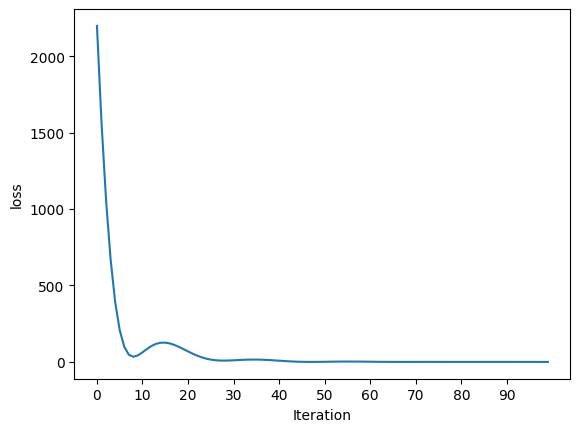

final representation:  [('Al', 53.938), ('Ch', 53.656), ('Ne', 52.875), ('Pl', 52.719), ('Mon', 51.594)]


In [12]:
from src.corner import CornerEstimator

corner_estimator = CornerEstimator(mt.model, mt.tokenizer)
corner = corner_estimator.estimate_corner_with_gradient_descent(
    target_words = list(relation.range),
    verbose=True,
)

In [21]:
import copy
corner_operator = operators.LinearRelationOperator(
    mt = operator.mt,
    weight = operator.weight,
    bias = corner/5, ## setting bias = corner
    h_layer = operator.h_layer,
    z_layer = operator.z_layer,
    prompt_template = operator.prompt_template,
    subject_token_offset = operator.subject_token_offset,
)

In [22]:
corner_operator("United States", k=20).predictions

[PredictedObject(token='Al', prob=0.2526553273200989),
 PredictedObject(token='Ch', prob=0.1395295262336731),
 PredictedObject(token='Pl', prob=0.12704308331012726),
 PredictedObject(token='Ne', prob=0.08731535077095032),
 PredictedObject(token='Le', prob=0.025810368359088898),
 PredictedObject(token='Mon', prob=0.02207677625119686),
 PredictedObject(token='Pr', prob=0.02139754593372345),
 PredictedObject(token='Th', prob=0.02073921263217926),
 PredictedObject(token='P', prob=0.011453281156718731),
 PredictedObject(token='Sh', prob=0.009796510450541973),
 PredictedObject(token='Israel', prob=0.008919824846088886),
 PredictedObject(token='Sp', prob=0.008919824846088886),
 PredictedObject(token='Sl', prob=0.008645390160381794),
 PredictedObject(token='L', prob=0.007871718145906925),
 PredictedObject(token='An', prob=0.007167280651628971),
 PredictedObject(token='H', prob=0.006946766283363104),
 PredictedObject(token='N', prob=0.006525883451104164),
 PredictedObject(token='Can', prob=0.00

In [35]:
generated = mt.model.generate(
    mt.tokenizer("The capital of Pakistan is", padding=True, return_tensors="pt").input_ids.to(device),
)

mt.tokenizer.decode(generated[0])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'The capital of Pakistan is Islamabad. It is located in the north-western part of the country.'

In [ ]:
import seaborn as sns

sns.heatmap(operator.weight[300:375, 300:375].cpu().numpy())

In [ ]:
@torch.inference_mode()
def complete(prompt):
    inputs = mt.tokenizer(prompt, return_tensors="pt").to(device)
    outputs = mt.model(**inputs)
    top5 = torch.log_softmax(outputs.logits, dim=-1)[:, -1].topk(k=20, dim=-1).indices.squeeze().tolist()
    return [mt.tokenizer.decode(x) for x in top5]

complete("Bill Clinton was born in the year")

In [ ]:
dataset[0].prompt_templates

In [ ]:
estimator = operators.JacobianIclEstimator(
    mt=mt,
    h_layer=5,
    z_layer=27,
)
relation = dataset[0]
with torch.device(device):
    operator = estimator(relation.set(samples=relation.samples[10:15]))

In [ ]:
operator("Spain", k=10).predictions